In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Annotated, Sequence
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper

In [3]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
wolfram = WolframAlphaAPIWrapper()

ValidationError: 1 validation error for WolframAlphaAPIWrapper
__root__
  Did not find wolfram_alpha_appid, please add an environment variable `WOLFRAM_ALPHA_APPID` which contains it, or pass `wolfram_alpha_appid` as a named parameter. (type=value_error)

In [4]:
class AgentState(TypedDict):
    problem:str
    steps:List[str]
    current_step:str
    solution:str
    criticism:str
    errors: List[str]

In [6]:
class Steps(BaseModel):
    steps: List[str] = Field(description="List of steps to solve the problem")


class Solution(BaseModel):
    solution: str = Field(description="Solution to the current step")
    needs_calculation: bool = Field(description="Whether this steps needs calculation")


class Criticism(BaseModel):
    is_correct: bool = Field(description="Whether the solution is correct")
    feedback: str = Field(description="Feedback on the solution")

In [14]:
#Problem Solver Agents
def steps_planner(state: AgentState) -> AgentState:
    parser = PydanticOutputParser(pydantic_object=Steps)
    messages = [
        SystemMessage(content=f"You are a steps planner. Break down the problem-solving approach into detailed steps. {parser.get_format_instructions()}"),
        HumanMessage(content=f"Problem: {state['problem']}")
    ]
    response = llm.invoke(messages)
    steps = parser.parse(response.content)
    return {"steps":steps.steps, "current_step":steps.steps[0]}

def steps_solver(state:AgentState) -> AgentState:
    parser = PydanticOutputParser(pydantic_object=Solution)
    messages = [
        SystemMessage(content=f"You are a mathematical step solver. Solve the current step or indicate if it needs calculation. {parser.get_format_instructions()}"),
        HumanMessage(content=f"Problem: {state['problem']}\nCurrent step: {state['current_step']}")
    ]
    response = llm.invoke(messages)
    solution = parser.parse(response.content)
    return {"solution":solution.solution, "needs_calculation":solution.needs_calculation}

def equation_solver(state:AgentState) -> AgentState:
    result = wolfram.run(state["current_step"])
    return {"solution":result}

In [15]:
# Refiner agents
def critic(state: AgentState) -> AgentState:
    parser = PydanticOutputParser(pydantic_object = Criticism)
    messages = [
        SystemMessage(content=f"You are a mathematical solution critic. Evaluate the solution and provide feedback. {parser.get_format_instructions()}"),
        HumanMessage(content=f"Problem: {state['problem']}\nSolution: {state['solution']}")
    ]
    response = llm.invoke(messages)
    criticism = parser.parse(response.content)
    return {"criticism": criticism.feedback, "is_correct":criticism.is_correct}

def error_resolver(state: AgentState) -> AgentState:
    messages = [
        SystemMessage(content="You are an error resolver. Address the criticism and suggest improvements."),
        HumanMessage(content=f"Problem: {state['problem']}\nSolution: {state['solution']}\nCriticism: {state['criticism']}")
    ]
    response = llm.invoke(messages)
    return {"errors":state.get("errors",[])+[response.content]}

In [16]:
workflow = StateGraph(AgentState)

In [17]:
# Nodes
workflow.add_node("steps_planner", steps_planner)
workflow.add_node("steps_solver", steps_solver)
workflow.add_node("equation_solver", equation_solver)
workflow.add_node("critic", critic)
workflow.add_node("error_resolver", error_resolver)

In [18]:
# Edges
workflow.add_edge("steps_planner", "steps_solver")
workflow.add_edge("steps_solver", "critic")
workflow.add_edge("equation_solver", "critic")
workflow.add_edge("critic", "error_resolver")
workflow.add_edge("error_resolver", "steps_solver")

In [20]:
# Conditional edges
def step_decider(state: AgentState):
    if state.get("need_calculation", False):
        return "equation_solver"
    return "critic"

def critic_decider(state: AgentState):
    if state.get("is_correct", False):
        return END
    return "error_resolver"

workflow.add_conditional_edges(
    "steps_solver",
    step_decider,
    {
        "equation_solver":"equation_solver",
        "critic":"critic"
    }
)

workflow.add_conditional_edges(
    "critic",
    critic_decider,
    {
        END: END,
        "error_resolver":"error_resolver"
    }
)

In [21]:
workflow.set_entry_point("steps_planner")
graph = workflow.compile()

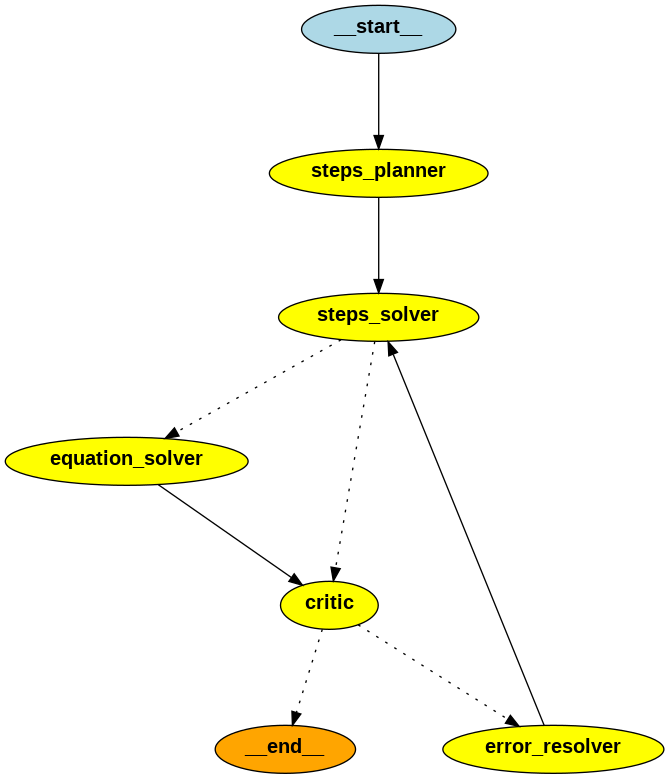

In [22]:
from IPython.display import Image 

Image(graph.get_graph().draw_png())